<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/nb40_iula_blurr_fastai_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr

     |████████████████████████████████| 2.6 MB 9.2 MB/s 
     |████████████████████████████████| 264 kB 42.7 MB/s 
     |████████████████████████████████| 76 kB 3.1 MB/s 
     |████████████████████████████████| 636 kB 35.7 MB/s 
     |████████████████████████████████| 895 kB 60.2 MB/s 
     |████████████████████████████████| 3.3 MB 63.2 MB/s 
     |████████████████████████████████| 243 kB 61.4 MB/s 
     |████████████████████████████████| 118 kB 76.8 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 14.1 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 188 kB 69.4 MB/s 
     |████████████████████████████████| 54 kB 4.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import pandas as pd

from transformers import AutoModelForSequenceClassification
from datasets import load_dataset

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, hf_splitter

from fastai.text.all import ColSplitter, ColReader, F1Score, accuracy, load_learner

### Leer Corpus

In [4]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [5]:

# pretained models
#   "distilbert-base-uncased"
#   "bert-base-uncased"
#   "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [6]:
model_cls = AutoModelForSequenceClassification


hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls,
    config_kwargs={'num_labels': num_labels})

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [7]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('sentence'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(co_df, bs=4, val_bs=8)

In [8]:
dls.show_batch(dataloaders=dls)

,text,category
0,"En una economía estacionaria quizá no valiera la pena mencionar todo esto, ya que en cada año los márgenes de tolerancia para la depreciación, con respecto a las casas viejas, quedarían compensados exactamente por las casas nuevas que se construyeran en sustitución de las que llegan al fin de su vida cada año; pero tales factores pueden ser de mucha importancia en una economía no estática, especialmente durante el periodo que sigue de inmediato a un vigoroso brote de inversión de capital a largo plazo; porque en tales circunstancias gran parte de las nuevas partidas de inversión puede ser absorbida por las mayores reservas financieras que hacen los empresarios para reparar y renovar el equipo de producción existente, el cual, aunque se desgasta con el tiempo, todavía no ha llegado a la fecha en que deben hacerse gastos que puedan aproximarse al total de la reserva financiera que se aparta; con la consecuencia de que los ingresos no pueden subir por encima de un nivel lo bastante bajo para corresponder a un total pequeño de inversión neta.",economía
1,"Sus aportaciones al análisis económico son muy considerables y se pueden clasificar del modo siguiente: 1) se encuentra en la base de todos sus escritos, implícita, pero claramente, la percepción de la lógica de las relaciones por las cuales las cosas se interrelacionan económicamente, mérito un tanto reducido -no tiene por qué serlo mucho- por la prioridad de Child, Barbon y otros; 2) Davenant ha mejorado considerablemente, aunque sólo, podría decirse, mediante un empírico método de casos, los conocimientos de su época en materia de dinero, comercio internacional y hacienda; 3) ha sido una de las primeras autoridades de la época en cuestiones de hacienda pública: impuestos, deuda, etc.; 4) ha sido uno de los pocos que han entendido la tarea de la aritmética política y han cooperado con ella.",economía
2,"Y también es verdad que siempre que intentamos interpretar actitudes humanas, sobre todo actitudes de hombres muy lejanos de nosotros cronológica o culturalmente, corremos el peligro de entenderlos mal no sólo si sustituimos groseramente sus actitudes por las nuestras, sino incluso cuando nos esforzamos cuanto podemos por penetrar en los modos de funcionamiento de su inteligencia; y esa situación se agrava aún por el hecho de que el mismo observador analista es producto de un determinado ambiente social -y de su situación personal en ese ambiente- que le condiciona para ver unas cosas y no otras y para verlas bajo una luz determinada.",economía
3,"Si bien no está claro todavía la aportación económica que estén dispuestos a hacer o los gobiernos o la industria hacia el esfuerzo de investigación del cloro, parece que la industria, además de sus campañas de relaciones públicas para convencer al público que los compuestos del cloro son seguros, ha comenzado a estudiar opciones de sustitución en varias áreas donde hay señales crecientes de que la sociedad no está dispuesta a aceptar la incertidumbre científica y los riesgos.",ambiente


In [9]:
b = dls.one_batch()

len(b), b[0]['input_ids'].shape, b[1].shape, dls.c

(2, torch.Size([4, 343]), torch.Size([4]), 5)

In [10]:
model = HF_BaseModelWrapper(hf_model)
learn = Learner(dls, 
                model,
                opt_func=Adam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[F1Score(average=None)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)
learn = learn.to_fp16()
learn.freeze()


In [11]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.0002754228771664202)

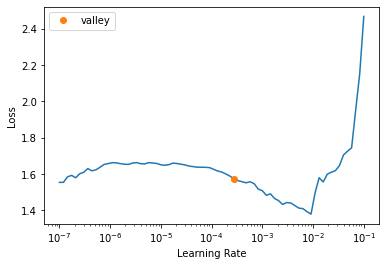

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.457684,0.406223,[0.68190476 0.68650372 0.7 0.89605157 0.85984355],04:36


In [14]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,legal
1,"Otro software empaquetado es Asymetrix Compel PE; el software de presentación multimedia Mind Path; el paquete de emulación de fax FaxWorks; el software para la transferencia de archivos TranXit, que puede utilizar el puerto serie, el puerto paralelo o una conexión interna de dos puertos con conexión mediante infrarrojos; el capturador de vídeo Digital Video Producing; un software reproductor de CD-I; y un grupo de aplicaciones Lotus que incluyen ScreenCam, cc:Mail Mobile, y Lotus Organizer 2.0.",tecnología,tecnología
2,"AL Departamento de Defensa de los Estados Unidos le atrajo la idea ya que en el evento de una catástrofe, como podía ser una guerra nuclear, los ordenadores de la nación podrían seguir comunicándose entre ellos incluso en el caso de que quedara destruida una cantidad considerable de la infraestructura de las comunicaciones, ya que aunque se caiga un enlace los datos pueden tomar otra ruta alternativa para llegar a su destino.",tecnología,tecnología
3,"[2] La voz 'técnica' se debe entender aquí en un sentido muy amplio: es suficiente para constituir nivel científico el mero dominio de los hechos de algún campo, si ese dominio se ha adquirido sistemáticamente y se sitúa más allá del alcance del conocimiento que se puede obtener en dicho campo por la mera práctica; y no tiene importancia que cultivar ese dominio no requiera métodos elaborados incomprensibles para el lego.",economía,economía
4,"Esta fortaleza del dólar se fundamenta en la buena situación de la economía norteamericana, que hace gala de un crecimiento sostenido, con pleno empleo y ausencia de tensiones inflacionistas, en un contexto internacional que le resulta muy favorable: contraste con la situación alemana, interés de Japón en depreciar el yen para relanzar su economía, dudas sobre el euro, etcétera.",economía,economía


### Evaluar

In [15]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.68190476, 0.68650372, 0.7       , 0.89605157, 0.85984355]),
 'loss': 0.4062231481075287}

In [16]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.4062) TensorBase(0.8488)


### Infererir

In [17]:
learn.export('iula_learner.pkl')

In [18]:
inf_learn = load_learner('iula_learner.pkl')

In [19]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
]))

[(('economía',),
  (#1) [tensor(1)],
  (#1) [tensor([0.1612, 0.7954, 0.0080, 0.0328, 0.0026])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([4.2736e-04, 5.6976e-04, 1.2228e-05, 9.9791e-01, 1.0844e-03])])]